
## Stroke Prediction Dataset
### 11 clinical features for predicting stroke events

In [1]:
# importing the needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations
sns.set_theme(style="whitegrid")


In [2]:
# import dataset
df = pd.read_csv("stroke-data.csv")
df.sample()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
231,12917,Female,79.0,0,0,Yes,Private,Urban,97.73,21.5,smokes,1


In [4]:
age_hyper = df.loc[:,["age","gender"]]
age_hyper

,age,gender
0,67.0,Male
1,61.0,Female
2,80.0,Male
3,49.0,Female
4,79.0,Female
...,...,...
5105,80.0,Female
5106,81.0,Female
5107,35.0,Female
5108,51.0,Male


In [5]:
age_hyper['age_cat'] = age_hyper.age.apply(lambda x :  "0-2" if 0 <= x<2 else
                                            "2-5" if 2<= x<= 5 else
                                            "6-13" if 5< x< 13 else
                                            "13-18" if 13<= x< 18 else
                                            "18-30" if 18<= x< 30 else
                                            "30-40" if 30<= x< 40 else
                                            "40-50" if 40<= x< 50 else
                                            "50-65" if 50<= x< 65 else
                                            "65+" if x>= 65 else "not known"
                                )

In [9]:
pivot_age = age_hyper.pivot_table(index = 'age_cat', columns='gender', values="age", aggfunc= 'count')
pivot_age

gender,Female,Male,Other
age_cat,,,
0-2,57.0,63.0,NaN
13-18,144.0,124.0,NaN
18-30,436.0,222.0,1.0
2-5,98.0,102.0,NaN
30-40,417.0,238.0,NaN
40-50,450.0,280.0,NaN
50-65,663.0,520.0,NaN
6-13,119.0,149.0,NaN
65+,610.0,417.0,NaN


<AxesSubplot:xlabel='age_cat'>

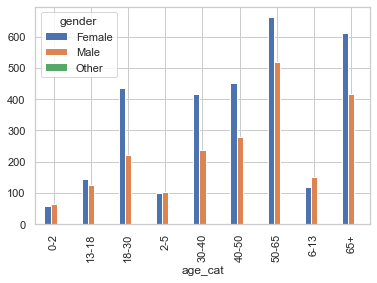

In [12]:
pivot_age.plot(kind = 'bar')

In [ ]:
df.age.value_counts()

In [ ]:
df.shape

In [ ]:
gender_stat = df.gender.value_counts().to_frame()
gender_stat

In [ ]:
sns.barplot(data = gender_stat, x = gender_stat.index, y = gender_stat['gender'] )

In [ ]:
# check for null values
df.isna().sum()

In [ ]:
df.stroke.value_counts().plot(kind= "pie", autopct = "%.1f%%", figsize = (10,10), explode = (0.01,0.05));

In [ ]:
df.age = df.age.astype("int")
df.bmi.fillna(df.bmi.mean(), inplace= True)

In [ ]:
fig,ax =plt.subplots(figsize = (14,6))
sns.regplot(df.bmi, df.age)

In [ ]:
# feature correlation
fig,ax =plt.subplots(figsize = (14,6))
feature_check =sns.heatmap(df.corr(), cmap = "Blues", annot = True)
feature_check

## Preprocessing , change strings to numeric with OneHotEncoder

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df.gender =le.fit_transform(df.gender)
df.work_type =le.fit_transform(df.work_type)
df.Residence_type =le.fit_transform(df.Residence_type)
df.smoking_status =le.fit_transform(df.smoking_status)

df.sample()

In [ ]:
# splitting the dataset into X an y
X = df.drop(["id","stroke","ever_married","work_type"], axis =1)
y = df.stroke
X.shape, y.shape
X

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)
X_res, y_res = sm.fit_resample(X, y)

In [ ]:
from sklearn.model_selection import train_test_split , cross_val_score
X_train,X_test ,y_train ,y_test = train_test_split(X_res,y_res, test_size = 0.3, random_state = 42)  
X_train.shape ,X_test.shape  ,y_train.shape ,y_test.shape

# Import needed estimators and libraries

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression(solver='lbfgs', max_iter=1000, random_state = 42)
lgr.fit(X_train,y_train)
print(f' Training -Set Accuracy score is {lgr.score(X_train, y_train)*100:.2f}%')
print(f' Testing - Set Accuracy score is {lgr.score(X_test, y_test)*100:.2f}%')
y_pred1 = lgr.predict(X_test)
cm = confusion_matrix(y_test, y_pred1)

print()
fig,ax = plt.subplots(figsize = (10,6))
sns.heatmap(pd.DataFrame(cm, columns =['no',"yes"], \
    index = ["no", "yes"]),cmap = 'Reds',xticklabels = True, annot =True,fmt = "d", ax = ax)
ax.set(title ="Confusion Matrix");

print()
cr1 = classification_report(y_test, y_pred1)
print(cr1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators= 100, n_jobs = 1 , random_state = 42)
clf.fit(X_train,y_train)

print(f' Training -Set Accuracy score is {clf.score(X_train, y_train)*100:.2f}%')
print(f' Testing - Set Accuracy score is {clf.score(X_test, y_test)*100:.2f}%')

y_pred2 = clf.predict(X_test)
confusion_mx = confusion_matrix(y_test, y_pred2)

conf_max_df = pd.DataFrame(confusion_mx, index =["Low Risk", "High risk"], columns =["Low Risk", "High risk"])

print()
fig,ax = plt.subplots(figsize = (5,3))
sns.heatmap(conf_max_df,\
cmap = 'Reds',xticklabels = True, annot =True,fmt = "d", ax = ax)
ax.set(title ="Confusion Matrix");

print()
cr2 = classification_report(y_test, y_pred2)
print(cr2)

In [ ]:
conf_max_df.to_csv("conf_max_df.csv", index = False)


## Save the model

In [ ]:
import pickle
pickle.dump(clf, open("estimator_pkl", "wb"))

In [ ]:
#import joblib
#joblib.dump("clf","estimator_jolib")